Okay, let's start over after we've understood some maths. 

In [720]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Setup:
X = np.load('data/X-data.npy')
y = np.load('data/y-data.npy')

error_viz = []

np.random.seed(0)

In [721]:
def split_test_train(X, y, rate=0.2):
    # First shuffle randomly 
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    X_shuffled, y_shuffled = X[p], y[p]
    
    # Split into test and train set
    i_test = round(len(X) * 0.2)
    X_test, X_train = X_shuffled[:i_test], X_shuffled[i_test:]
    y_test, y_train = y_shuffled[:i_test], y_shuffled[i_test:]
    
    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = split_test_train(X, y)

In [722]:
# Abstract Class Definitions: 
class Layer():
    def __init__(self): 
        self.inputs = None  # The inputs into this layer. 
        self.outputs = None # The ouputs of this layer. 
        
    # Forward propagation method.
    def forward(self, inputs):
        pass
    
    # Backward propagation method.
    def backward(self):
        pass
    
class Activation():
    def activate():
        pass
    
    def prime():
        pass
    
class Loss():
    def calculate_loss():
        pass

In [723]:
class ReLU(Activation):
    def activate(self, x): 
        return np.maximum(x, 0.0)
    
    def derivative(self, x):
        return (x > 0) * 1  # * 1 to return a number.
    
class Sigmoid(Activation):
    def activate(self, x):
        return 1 / (1 + np.exp(-x))
    
    def derivative(self, x):
        s = self.activate(x)
        return s * (1 - s)

In [724]:
class CrossEntropyLoss():
    def calculate_loss(self, y_true, y_pred):
        return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))
    
    def derivative(self, y_true, y_pred): 
        r = ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)
        return r
    
class MSELoss():
    def calculate_loss(self, y_true, y_pred):
        return 1/2 * (y_true - y_pred)**2
    
    def derivative(self, y_true, y_pred):
        return y_pred - y_true  # (y_true - y_pred) * (-1)

In [725]:
# Dense (fully connected) Layer Class:
class Dense(Layer): 
    def __init__(self, input_size, output_size, activation_function='relu', name='unnamed'):
        self.name = name
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros((output_size, 1))
        self.outputs = None
        
        if activation_function == 'relu':
            self.activation = ReLU()
        elif activation_function == 'sigmoid':
            self.activation = Sigmoid()
        else:
            self.activation = ReLU()  # Default to ReLU activation function.
        
    def print_weights(self):
        print('Weights:\n', pd.DataFrame(self.weights))
        
    def print_biases(self):
        print('Biases:\n', pd.DataFrame(self.biases))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = self.activation.activate(np.dot(self.weights, inputs) + self.biases)
        return self.outputs
    
    def backward(self, delta_l, learning_rate):
        self.weights -= learning_rate * np.dot(self.outputs.T, delta_l)
        return delta_l

In [726]:
class Network:
    def __init__(self, layers, loss_function='cross_entropy'):
        self.layers = layers
        self.output = None
        
        if loss_function == 'cross_entropy':
            self.loss = CrossEntropyLoss()
        elif loss_function == 'mse':
            self.loss = MSELoss()
        else:
            self.loss = CrossEntropyLoss()  # Default to cross entropy loss. 
    
    def train(self, X_train, y_train, number_epochs, learning_rate=0.1):
        for epoch in range(number_epochs):
            error_v = 0
            
            for x, y in zip(X_train, y_train):
                # Process the forward pass. This goes through every layer.
                x = x.reshape(21, 1)  # Create a matrix for dot product in forward()
                y_hat = self.predict(x)  
                
                # Calculate the error after the forward pass. 
                loss = self.loss.calculate_loss(y, y_hat)
                error = self.loss.derivative(y, y_hat)
                error_v += loss[0][0]
                
                l0 = self.layers[0]
                l1 = self.layers[1]
                
                # The output layer error.
                delta_L = np.multiply(error, l1.activation.derivative(l1.outputs))
                
                delta_L_transposed = delta_L.T
                
                part_1 = np.dot(delta_L_transposed, l1.weights)
                # print('part 1', part_1.shape)  # (1, 2)
                
                part_2 = l0.activation.derivative(l0.outputs).T
                # print('part 2', part_2.shape)  # (1, m) -> (1, 2)
                
                part_3 = np.dot(delta_L_transposed, l1.weights) * l0.activation.derivative(l0.outputs).T
                # print('part 3', part_3)  # (1, 2)
                
                gradient_l0 = np.dot(delta_L_transposed, l1.weights) * l0.activation.derivative(l0.outputs).T * np.dot(x, np.ones((1, 2)))
                
                # print('np dot', np.dot(x, np.ones((1, 2))))
                # print('gradient', gradient_l0)
                
                pd_irt_weights = l0.outputs.T * delta_L
                l1.weights -= learning_rate * pd_irt_weights
                
                l0.weights -= learning_rate * gradient_l0.T         
                
                # The hidden layer error.
            
            error_v /= len(X)
            error_viz.append(error_v)
                
                   
    def predict(self, x):
        outputs = x
        for layer in self.layers:
            outputs = layer.forward(outputs)
        self.output = outputs
        return outputs
            

For backpropagation, the formula for the very last layer is: 
![last-layer-backprop](https://miro.medium.com/max/828/1*zRDMl-GxVO7qENH5dNrZ-g.png)

In [727]:
np.random.seed(12)  # To keep results consistent.

number_inputs = X.shape[1]
epochs = 1000

layers = [
    Dense(number_inputs, 2, activation_function='sigmoid', name='Layer 1'),
    Dense(2, 1, activation_function='sigmoid', name='Layer 2')
]

In [728]:
def print_layer_outputs(network):
    for layer in network.layers:
        print(layer.name, layer.outputs.shape, ':\n', layer.outputs)

In [729]:
network = Network(layers, loss_function='mse')
network.train(X, y, number_epochs=epochs)
# print_layer_outputs(network)

C:\Users\Laura\AppData\Local\Temp\ipykernel_8056\704273480.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


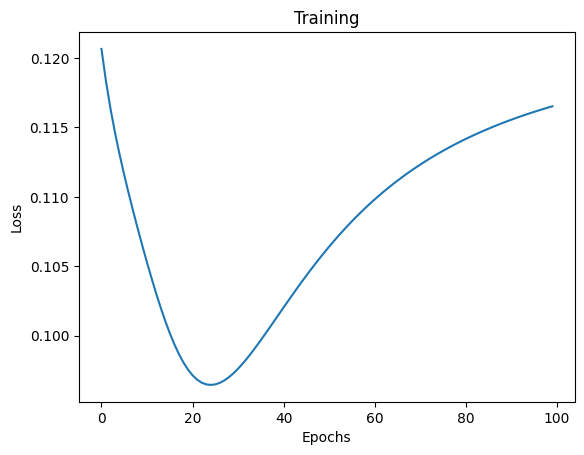

In [ ]:
plt.plot(error_viz)
plt.title("Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
pred = []
for i in X:
    pred.append(network.predict(i.reshape(21, 1)))

In [ ]:
res = pd.DataFrame()
res["predictions"] = pred
res["actual"] = y

In [ ]:
res["predictions"] = res["predictions"].apply(lambda x: x[0][0])
res["predictions"] = res["predictions"].apply(lambda x: 0 if x < 0.5 else 1)

In [ ]:
print("Accuracy:", sum(x == y for x, y in zip(res['predictions'], res['actual'])) / len(X) * 100)

Accuracy: 62.741652021089635
